In [1]:
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2

--2019-05-03 18:36:27--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  12.4MB/s    in 82s     

2019-05-03 18:37:49 (14.5 MB/s) - ‘RML2016.10b.tar.bz2’ saved [1245608913/1245608913]



In [0]:
import tarfile
tar = tarfile.open("RML2016.10b.tar.bz2", "r:bz2")
tar.extractall()
tar.close()

In [0]:
import keras
import numpy as np
import theano as th
import pickle
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from sklearn import preprocessing
from keras import optimizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import gc

In [0]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = pickle.load(open("RML2016.10b.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [0]:
# make 1's diff
#X1 = np.gradient(X, axis = 0)

In [0]:
# make integration 
#X2 = integrate.cumtrapz(X, None, initial=0)

In [0]:
#newDataSet=[]
#for i in range (len(X)):
#    newDataSet.append(np.vstack((X[i], X1[i], X2[i])))
#newDataSet = np.array(newDataSet)    

In [0]:
#del(X)
#del(X1)
#del(X2)
#gc.collect()

0

In [7]:
#print X1.shape
print X.shape
print len (lbl)
#print X2.shape
#print newDataSet.shape
#print X[0][0]
#print X1[0][0]
print lbl[2]
#print X[2]

(1200000, 2, 128)
1200000
('8PSK', -20)


In [0]:
#spliting data even odd 50%
def splitData(X):
  trainingSet, testSet, trainingLabel, testLabel = train_test_split(X, lbl, test_size = 0.5)
  trainingLabel = [label[0] for label in trainingLabel]
  testLabel = [label[0] for label in testLabel]

  print("training data size: %d" % len(trainingSet))
  print("test data size: %d" % len(testSet))
  print("training data labels size: %d" % len(trainingLabel))
  print("test data labels size: %d" % len(testLabel))
  return trainingSet, testSet, trainingLabel, testLabel

In [18]:
trainingSet, testSet, trainingLabel, testLabel = splitData(X)

training data size: 600000
test data size: 600000
training data labels size: 600000
test data labels size: 600000


In [0]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)


training_integer_encoded = label_encoder.fit_transform(np.array(trainingLabel))
training_integer_encoded = training_integer_encoded.reshape(len(training_integer_encoded), 1)
trainingLabel = onehot_encoder.fit_transform(training_integer_encoded)


test_integer_encoded = label_encoder.fit_transform(np.array(testLabel))
test_integer_encoded = training_integer_encoded.reshape(len(test_integer_encoded), 1)
testLabel = onehot_encoder.fit_transform(test_integer_encoded)

In [22]:
model = Sequential()
model.add(Dense(512, input_shape=(2,128), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Fit the model
history = model.fit(trainingSet, trainingLabel, epochs=60, batch_size=64, validation_split=0.05, callbacks=[EarlyStopping(patience=5,  mode='min')])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2, 512)            66048     
_________________________________________________________________
dense_2 (Dense)              (None, 2, 256)            131328    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 202,506
Trainable params: 202,506
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 570000 samples, validate on 30000 samples
Epoch 1/60
570000/570000 [==============================] - 65s 114us/step - loss: 1.5757 - acc: 

In [26]:
score = model.evaluate(testSet, testLabel, verbose=0, batch_size=60)
print score

[7.852913689041138, 0.09992500277645885]


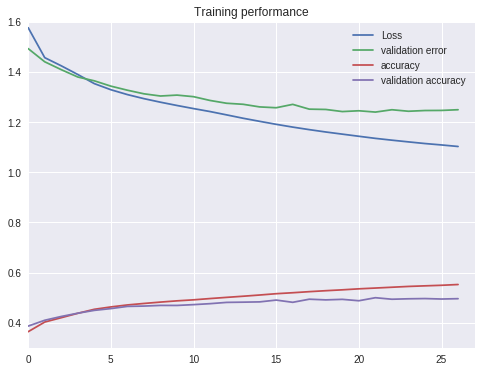

In [98]:
plt.figure(figsize=(8, 6))
ax = plt.gca()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='Loss')
plt.plot(history.epoch, history.history['val_loss'], label='validation error')
plt.plot(history.epoch, history.history['acc'], label='accuracy')
plt.plot(history.epoch, history.history['val_acc'], label='validation accuracy')
plt.xlim((0,27))
plt.ylim((0.3,1.6))
plt.grid(True,color='white')
plt.legend()